In [1]:
import pickle

In [2]:
user_points_x = pickle.load(open('user_points_x.sav', 'rb'))
user_points_y = pickle.load(open('user_points_y.sav', 'rb'))

In [3]:
x_poison = pickle.load(open('x_poison.sav', 'rb'))
y_poison = pickle.load(open('y_poison.sav', 'rb'))

In [4]:
mixed_points_x = user_points_x.append(x_poison)
mixed_points_y = user_points_y.append(y_poison)

In [5]:
mixed_points_x = mixed_points_x.sample(frac = 1) 
mixed_points_y = mixed_points_y.sample(frac = 1) 

In [6]:
print(mixed_points_x.shape, mixed_points_y.shape)

(70500, 23) (70500, 1)


In [7]:
mixed_points_x.head()

,loan_amnt,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,open_acc,pub_rec_1,revol_bal,revol_util,...,emp_length,earliest_cr_line,mths_since_last_delinq,mths_since_last_record,mths_since_last_major_derog,term_36months,addr_state,purpose,home_ownership,verification_status
21332,0.808344,0.088977,0.050336,0.00,0.036801,0.000,0.009690,0.0,0.001349,0.089482,...,1.000000,1.146541,1.0,1.000000,1.000000,1.0,11.0,1.0,4.0,1.0
41097,0.954635,0.014944,0.457517,0.00,0.009375,0.002,0.031649,1.0,0.000213,0.001294,...,0.565676,1.264146,1.0,1.000000,0.162865,0.0,32.0,13.0,4.0,1.0
25075,0.690389,0.084881,0.015668,0.05,0.000000,0.000,0.182752,0.0,0.004164,0.080955,...,0.417488,0.775165,1.0,1.000000,1.000000,1.0,5.0,5.0,2.0,1.0
10457,0.626395,0.008112,0.152088,0.00,0.000000,0.000,0.150670,0.0,0.005243,0.063335,...,1.000000,0.990080,1.0,1.000000,1.000000,1.0,20.0,1.0,2.0,1.0
29100,0.230550,0.080481,0.029130,0.00,0.000000,0.002,0.151016,0.0,0.003356,0.024388,...,1.000000,0.353356,1.0,0.349749,1.000000,1.0,35.0,13.0,4.0,1.0


In [8]:
mixed_points_y.head()

,0
13224,-0.200000
17217,0.700000
8099,0.206491
6949,-0.200000
28908,0.440082


In [9]:
x_clean = pickle.load(open('X_preprocessed.sav', 'rb'))
y_clean = pickle.load(open('Y_preprocessed.sav', 'rb'))

In [10]:
print(x_clean.shape, y_clean.shape)

(168048, 23) (168048, 1)


In [11]:
import pandas as pd

In [12]:
df_chunks = []

In [13]:
i = 0
for _ in range(50):
    if i+500 < len(mixed_points_x):
        df_chunks.append(mixed_points_x.iloc[i:i + 500, :])
    else:
        df_chunks.append(mixed_points_x.iloc[i:, :])
    i = i + 500

In [14]:
count = 0
for chunk in df_chunks:
    count += 1
    #print(chunk)
print(count)

50


In [15]:
y_chunks = []
i = 0
for _ in range(50):
    if i+500 < len(mixed_points_y):
        y_chunks.append(mixed_points_y.iloc[i:i + 500, :])
    else:
        y_chunks.append(mixed_points_y.iloc[i:, :])
    i = i + 500

In [16]:
count = 0
for chunk in y_chunks:
    count += 1
    #print(chunk)
print(count)

50


In [17]:
filename = 'original_model.sav'
clean_model = pickle.load(open(filename, 'rb'))

In [18]:
x_clean = pickle.load(open('X_preprocessed.sav', 'rb'))
y_clean = pickle.load(open('Y_preprocessed.sav', 'rb'))

In [19]:
from sklearn.metrics import mean_squared_error

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [21]:
print(x_clean.shape, y_clean.shape)

(168048, 23) (168048, 1)


In [22]:
x_new = x_clean
y_new = y_clean

In [23]:
rmse_array = []

In [24]:
for _ in range(10):

    least_error_df = pd.DataFrame()
    min_error = 10000000
    least_error_index = 10000000
    
    for index, chunk in enumerate(df_chunks):
        #print("At index:", index)
        y_pred = clean_model.predict(chunk)
        rmse = mean_squared_error(y_chunks[index], y_pred)
        #print("rmse of current chunk: ", rmse)
        if(rmse < min_error):
            min_error = rmse
            least_error_df = chunk
            least_error_index = index
            #print("Min error is now: ", min_error)

    
    least_error_df = pd.DataFrame(least_error_df.iloc[:,:].values)    
    x_new = x_new.append(least_error_df)
    y_new = y_new.append(y_chunks[least_error_index])

    del df_chunks[least_error_index]
    del y_chunks[least_error_index]
    
    print(x_new.shape, y_new.shape)

    X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, test_size=0.3, random_state=0)
    regressor = LinearRegression()  
    LIR=regressor.fit(X_train, y_train) 
    y_clean_pred = LIR.predict(x_clean)

    from sklearn.metrics import mean_squared_error
    rmse = mean_squared_error(y_clean, y_clean_pred)
    rmse_array.append(rmse)
    print(rmse)


(168548, 23) (168548, 1)
0.021305536978549974
(169048, 23) (169048, 1)
0.02130732288024151
(169548, 23) (169548, 1)
0.021313944648727528
(170048, 23) (170048, 1)
0.02132024651424702
(170548, 23) (170548, 1)
0.02133911562233104
(171048, 23) (171048, 1)
0.02134328228080428
(171548, 23) (171548, 1)
0.021352145064669852
(172048, 23) (172048, 1)
0.02137506641646918
(172548, 23) (172548, 1)
0.02139934153739532
(173048, 23) (173048, 1)
0.021416543434724974


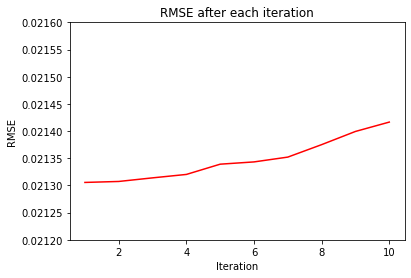

In [35]:
import numpy as np  
import matplotlib.pyplot as plt  
  
# data to be plotted 
x = [1,2,3,4,5,6,7,8,9,10]
y = rmse_array
  
# plotting 
plt.title("RMSE after each iteration")  
plt.xlabel("Iteration")  
plt.ylabel("RMSE")  
plt.ylim([0.0212, 0.0216])
plt.plot(x, y, color ="red")  
plt.show()

In [26]:
print(x_new.shape, y_new.shape)

(173048, 23) (173048, 1)


In [27]:
print(len(df_chunks), len(y_chunks))

40 40


In [28]:
rmse_clean = pickle.load(open('rmse_clean.sav', 'rb'))

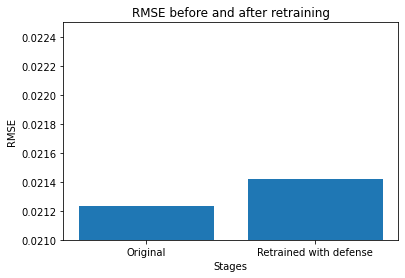

In [29]:
x = ['Original', 'Retrained with defense']
y = [rmse_clean, rmse_array[-1]]
  
# plotting 
plt.title("RMSE before and after retraining")  
plt.xlabel("Stages")  
plt.ylabel("RMSE")  
plt.ylim([0.021, 0.0225])
plt.bar(x, y)  
plt.show()